In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

import sys
#src\FastTest.py
sys.path.insert(1, "../src")

from FastTest import FastTest
from Exchange import Exchange
from Broker import Broker
from Strategy import Strategy
from Asset import Asset
from Order import *

In [2]:
fast_ma = 20
slow_ma = 50
csv_path = r"C:\Users\bktor\Desktop\Python\FastTest\tests\data\AAPL.csv"
dateparser = lambda x: datetime.strptime(x, "%Y-%m-%d")
df = pd.read_csv(
    filepath_or_buffer = csv_path,
    engine = 'c',
    parse_dates = ["DATE"],
    date_parser = dateparser,
    index_col = "DATE"
)
df = df[["OPEN","HIGH","LOW","CLOSE","VOL"]]
df[f"sma_{fast_ma}"] = df["CLOSE"].rolling(fast_ma).mean()
df[f"sma_{slow_ma}"] = df["CLOSE"].rolling(slow_ma).mean()
df = df.head(1000)
df.reset_index(inplace = True)
df.to_csv(csv_path, index = False)
df

,DATE,OPEN,HIGH,LOW,CLOSE,VOL,sma_20,sma_50
0,1984-09-07,0.100930,0.102168,0.099711,0.100930,9.751428e+07,NaN,NaN
1,1984-09-10,0.100930,0.101239,0.098503,0.100331,7.568699e+07,NaN,NaN
2,1984-09-11,0.101239,0.103986,0.101239,0.102168,1.784744e+08,NaN,NaN
3,1984-09-12,0.102168,0.102767,0.099092,0.099092,1.559126e+08,NaN,NaN
4,1984-09-13,0.104605,0.104904,0.104605,0.104605,2.428281e+08,NaN,NaN
...,...,...,...,...,...,...,...,...
995,1988-08-15,0.322043,0.322043,0.308501,0.314333,1.952122e+08,0.331345,0.339236
996,1988-08-16,0.312586,0.329612,0.310738,0.323820,1.437660e+08,0.330477,0.339003
997,1988-08-17,0.323820,0.325937,0.318308,0.320185,1.393061e+08,0.329626,0.338698
998,1988-08-18,0.320185,0.327855,0.318308,0.323820,8.674497e+07,0.329424,0.338314


In [3]:
exchange = Exchange()
broker = Broker(exchange=exchange)

source_type = "csv"
datetime_format = "%Y-%m-%d"
datetime_column = "DATE"

exchange.register_asset(Asset(
            "AAPL",
            source_type = source_type,
            csv_path = r"C:\Users\bktor\Desktop\Python\FastTest\tests\data\AAPL.csv",
            datetime_format = datetime_format,
            datetime_column = datetime_column,
            warmup = slow_ma-1,
            frequency = "1D"
        )
    )

fast_test = FastTest(
    exchange=exchange,
    broker=broker
)

class BasicMovingAverageStrategy(Strategy):
    def __init__(self, exchange: Exchange, broker: Broker) -> None:
        super().__init__(exchange, broker)

    def next(self):
        position = self.broker.portfolio.get("AAPL")
        sma_fast = self.exchange.market_view["AAPL"][f"sma_{fast_ma}"]
        sma_slow = self.exchange.market_view["AAPL"][f"sma_{slow_ma}"]

        if position == None:
            if sma_fast > sma_slow:
                new_order = MarketOrder(
                    order_create_time = self.exchange.market_time,
                    asset_name = "AAPL",
                    units = 100
                )
                return [new_order]
        else:
            if sma_fast < sma_slow:
                new_order = MarketOrder(
                    order_create_time = self.exchange.market_time,
                    asset_name = "AAPL",
                    units = -100
                )
                return [new_order]

strategy = BasicMovingAverageStrategy(
            exchange=exchange,
            broker=broker
        )
fast_test.register_strategy(strategy)
fast_test.run()

In [4]:
strategy_analysis = broker.strategy_analysis
position_history = broker.position_history
portfolio_value_history = fast_test.portfolio_value_history
strategy_analysis

{'AAPL': {'commision_paid': 0,
  'time_in_market': numpy.timedelta64(619,'D'),
  'total_units': 900,
  'pl': 17.342859999999988,
  'number_trades': 9,
  'wins': 5,
  'losses': 4,
  'win_rate': 0.5555555555555556,
  'average_time_in_market': numpy.timedelta64(68,'D'),
  'average_position_size': 100.0,
  'average_pl': 1.926984444444443}}

In [5]:
df_test = portfolio_value_history
df_test = pd.merge(df_test,fast_test.exchange.market["AAPL"].df, left_index=True,right_index=True)

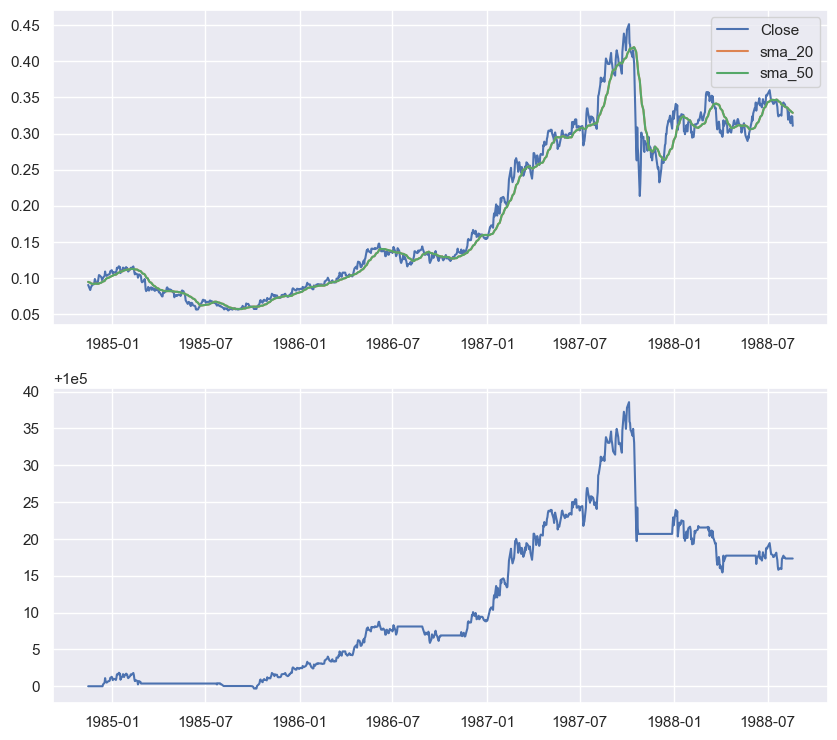

In [6]:
fig = plt.figure(figsize=(10,9))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)


ax1.plot(df_test["CLOSE"], label = "Close")
ax1.plot(df_test[f"sma_{fast_ma}"], label = f"sma_{fast_ma}")
ax1.plot(df_test[f"sma_{fast_ma}"], label = f"sma_{slow_ma}")

ax2.plot(df_test["net_liquidation_value"])

ax1.legend()